In [1]:
import PyPDF2
from nltk import word_tokenize 
from nltk.util import ngrams
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from dictionary import *
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# filename is test.pdf

In [2]:
def get_text(file):
    pdfFileObj = open(file, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFileObj)
    text = ''
    num_pages = len(pdfReader.pages)
    for i in range(num_pages):
        pageObj = pdfReader.pages[i]
        text += pageObj.extract_text()
    pdfFileObj.close()
    return text

def get_string_from_list(list):
    string = ''
    for i in range(len(list)):
        string += list[i]
        if i != len(list)-1:
            string += ' '
    return string

def filter(text):
    token = word_tokenize(text)
    token = [word.lower() for word in token]
    token = [word for word in token if word.isalpha()]
    token = [word for word in token if not word in stop_words]
    # remoev single character
    token = [word for word in token if len(word) > 1]
    # remove th
    token = [word for word in token if word != 'th']
    for i in range(len(token)):
        if token[i] == 'per' and token[i+1] == 'cent':
            token[i] = 'percent'
            token[i+1] = ''
    token = [word for word in token if word != '']
    return token


def get_bigram(token):
    token = [stemmer.stem(word) for word in token]
    bigram = ngrams(token, 2)
    return list(bigram)

In [3]:
def searchAndCountHawkish_single(bigram_list, term, hdlist):
    count = 0
    for i in range(len(bigram_list)):
        if term in bigram_list[i]:
            for j in range(len(hdlist)):
                if i-7 < 0:
                    for k in range(i+7):
                        if hdlist[j] in bigram_list[k]:
                            count += 1
                elif i+7 > len(bigram_list):
                    for k in range(i, len(bigram_list)):
                        if hdlist[j] in bigram_list[k]:
                            count += 1
                else:
                    for k in range(i-7, i+7):
                        if hdlist[j] in bigram_list[k]:
                            count += 1
    return count


def searchAndCountHawkish_double(bigram_list, term1, term2, hdlist):
    count = 0
    for i in range(len(bigram_list)):
        if term1 in bigram_list[i] and term2 in bigram_list[i]:
            for j in range(len(hdlist)):
                if i-7 < 0:
                    for k in range(i+7):
                        if hdlist[j] in bigram_list[k]:
                            count += 1
                elif i+7 > len(bigram_list):
                    for k in range(i, len(bigram_list)):
                        if hdlist[j] in bigram_list[k]:
                            count += 1
                else:
                    for k in range(i-7, i+7):
                        if hdlist[j] in bigram_list[k]:
                            count += 1
    return count

def searchAndCountHawish_triple(trigram_list, term1, term2, term3, hdlist):
    count = 0
    for i in range(len(trigram_list)):
        if term1 in trigram_list[i] and term2 in trigram_list[i] and term3 in trigram_list[i]:
            for j in range(len(hdlist)):
                if i-7 < 0:
                    for k in range(i+7):
                        if hdlist[j] in trigram_list[k]:
                            count += 1
                elif i+7 > len(trigram_list):
                    for k in range(i, len(trigram_list)):
                        if hdlist[j] in trigram_list[k]:
                            count += 1
                else:
                    for k in range(i-7, i+7):
                        if hdlist[j] in trigram_list[k]:
                            count += 1
    return count


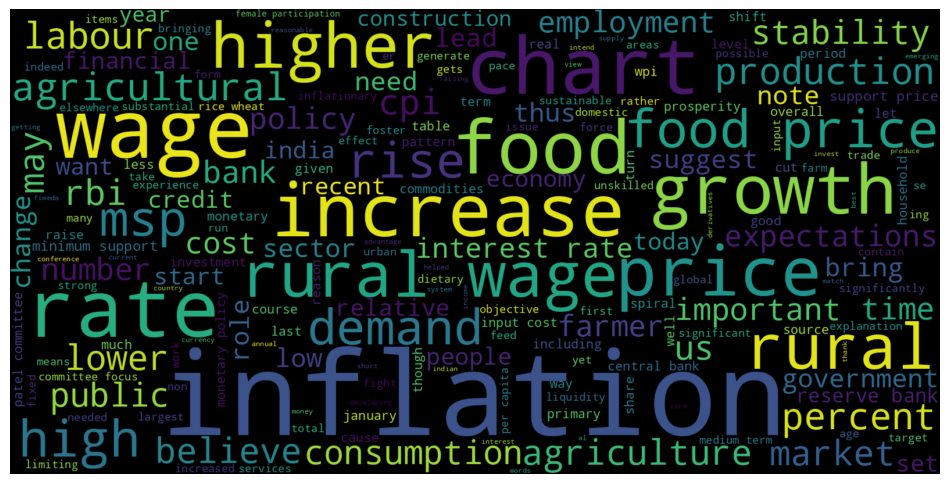

In [4]:
text = get_text('test.pdf')
token = filter(text)
string_list = get_string_from_list(token)
bigram_list = get_bigram(token)
term1 = stemmer.stem('inflation')
term2 = stemmer.stem('pressure')



wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(string_list)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [5]:
print(searchAndCountHawkish_double(bigram_list, term1, term2, ConsumerPricesInflation_Hawkish))

0


In [6]:
# make the bigram_list into dictionary with the index as the key and the bigram as the value

def make_bigram_dict(bigram_list):
    bigram_dict = {}
    for i in range(len(bigram_list)):
        bigram_dict[i] = bigram_list[i]
    return bigram_dict

bigram_dict = make_bigram_dict(bigram_list)

# dump to json in readable format
import json
with open('bigram_dict.json', 'w') as fp:
    json.dump(bigram_dict, fp, indent=4)

In [7]:
# make a standard topic model for the text file
from gensim import corpora
dictionary = corpora.Dictionary([token])
corpus = [dictionary.doc2bow(token)]
from gensim import models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=1)
print(lda.print_topics(num_topics=4, num_words=4))

[(0, '0.001*"plan" + 0.001*"play" + 0.001*"place" + 0.001*"pesticides"')]


/home/uttkarsh/.local/lib/python3.8/site-packages/gensim/models/ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [8]:
print(corpus_tfidf)

In [9]:
with open('token.json', 'w') as fp:
    json.dump(token, fp, indent=4)

In [ ]:
# Calculating net hawkishness

hawk = cpi_hawkish + ip_hawkish + cs_hawkish + ea_hawkish + ru_hawkish + e_hawkish + lm_hawkish + ue_hawkish
dove = cpi_dovish + ip_dovish + cs_dovish + ea_dovish + ru_dovish + e_dovish + lm_dovish + ue_dovish

net_hawkishness = 1 + ((hawk - dove) / (hawk + dove))

print(net_hawkishness)

In [ ]:
cpi_hawkish = searchAndCountHawkish(bigram_list, term, ConsumerPricesInflation_Hawkish)
# print(cpi_hawkish)
cpi_dovish = searchAndCountDovish(bigram_list, term, ConsumerPricesInflation_Dovish)
# print(cpi_dovish)

ip_hawkish = searchAndCountHawkish(bigram_list, term, InflationPressure_Hawkish)
# print(ip_hawkish)
ip_dovish = searchAndCountDovish(bigram_list, term, InflationPressure_Dovish)
# print(ip_dovish)

cs_hawkish = searchAndCountHawkish(bigram_list, term, ConsumerSpending_Hawkish)
# print(cs_hawkish)
cs_dovish = searchAndCountDovish(bigram_list, term, ConsumerSpending_Dovish)
# print(cs_dovish)

ea_hawkish = searchAndCountHawkish(bigram_list, term, EconomicActivity_Hawkish)
# print(ea_hawkish)
ea_dovish = searchAndCountDovish(bigram_list, term, EconomicActivity_Dovish)
# print(ea_dovish)

ru_hawkish = searchAndCountHawkish(bigram_list, term, ResourceUtilization_Hawkish)
# print(ru_hawkish)
ru_dovish = searchAndCountDovish(bigram_list, term, ResourceUtilization_Dovish)
# print(ru_dovish)

e_hawkish = searchAndCountHawkish(bigram_list, term, Employment_Hawkish)
# print(e_hawkish)
e_dovish = searchAndCountDovish(bigram_list, term, Employment_Dovish)
# print(e_dovish)

lm_hawkish = searchAndCountHawkish(bigram_list, term, LaborMarket_Hawkish)
# print(lm_hawkish)
lm_dovish = searchAndCountDovish(bigram_list, term, LaborMarket_Dovish)
# print(lm_dovish)

ue_hawkish = searchAndCountHawkish(bigram_list, term, Unemployment_Hawkish)
# print(ue_hawkish)
ue_dovish = searchAndCountDovish(bigram_list, term, Unemployment_Dovish)
# print(ue_dovish)